# 0D Thermal Analysis for Generic Systems

Many electrical and mechanical components and systems have their thermal performance characterised by a simple thermal resistance model. This gives a value $k$, K/W, or temperature rise per unit power output. This can be simply multiplied by power dissipation to find temperature rise above ambient. The exact value can be calculated (for simple cases, such as uniform flow over a finned heat sink) but is generally easier and more practical to determine experimentally. The value of thermal resistance depends on many factors - geometry, flow, air properties and many other. 

Clearly it will be dramatically different on Mars compared to the benign environment of Earth. It is highly desirable to be able to approximate the thermal resistance of an arbitrary system on Mars, given data for Earth. This requires considering the different gas properties of the thin CO2 atmosphere, the lower ambient temperature and the lower gravity.

## Common Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Prandtl number
Pr_earth = 0.71
Pr_mars = 0.74

# Density, kg/m3
rho_earth = 1.2
rho_mars = 0.0143

# Kinematic Viscosity, m2/s
visc_kinem_earth = 1.48e-5
visc_kinem_mars = 7.62e-4

# Mean ambient temperature, K
T_amb_earth = 294
T_amb_mars = 210

# Thermal conductivity, W/(m K)
lambda_earth = 24e-3
lambda_mars = 8.74e-3

## Forced (fan-driven) Air-Cooled Systems

A great many high-power systems (such as electric drive motors) utilise forced air cooling to reduce temperatures. A common example of this is the standard IEC motor casing, which uses a fan mounted on the main axle to drive air over external cooling fins. Another example may be found in vehicle radiators.

The behaviour of these systems are generally described primarily in terms of heat transfer coefficient $h$, given as $h = \frac{P}{A \Delta T}$. For the purposes of analysis of simple systems, $h$ is further abstracted with the definition of Nusselt number $Nu$ - a non-dimensional heat transfer coefficient. $Nu$ is given as $\frac{h L}{\lambda}$, where $L$ is some characteristic length or diameter of the system and $\lambda$ is the thermal conductivity of the flowing fluid.

For a very large number of geometries, correlations for $Nu$ in terms of other fluid properties are defined. In simple cases, these most commonly take the form given in Equation 1. $Re$ is the Reynolds number (non-dimensionalising the flow), $Pr$ is the Prandtl number (non-dimensionalising the fluid properties) and $a, b$ and $c$ are coefficients that vary with different geometries.

\begin{equation}
    Nu = a Re^b Pr^c
\end{equation}

The value of the coefficients $a, b$ and $c$ determine the precise heat transfer properties of a given geometry. $a$ is very variable, commonly taking values between 0.01 and 1. $c$ is equal to 1/3 in practically every case. $b$ presents the most difficulty, varying with both geometry and laminar versus turbulent flow regime. This variation occurs generally in the region of 0.6 to 0.85 for turbulent flow, and 0.33 to 0.65 for laminar flow. 

This relationship can be used to scale the heat loss between Earth and Mars cases. Knowledge of the kinematic viscosity of the atmospheres of both planets allows the ratio of Reynolds' numbers to be found. The ratio of Prandtl numbers and an assumption about the coefficient $b$ in Equation 1 gives the scaled Nusselt number. Finally, the ratio of thermal conductivities gives $h$ and finally thermal resistance.

### Assumptions in Calculations

- All gases behave as ideal, on both Earth and Mars. Humidity, compressibility and thermal expansion effects are all neglected
- Flow is assumed to be turbulent, due to the probable geometric complexity of heat transfer surfaces causing flow to be tripped at an early point.
- Thus, the value of the coefficient $b$ in Equation 1 is assumed to be constantly 0.8. This is the value for a flat plate at zero incidence, ans is close to both a cylinder (0.805) and flat plate with flow incident to the surface (0.731)
- The value of the coefficient $c$ is taken to be 1/3
- Gas properties are considered constant, given above in the Common Setup section
- Geometries and flow velocity are constant on both Earth and Mars

In [3]:
def scale_Nu(Nu_earth):
    Nu_mars = Nu_earth 
    Nu_mars *= np.power(visc_kinem_earth / visc_kinem_mars, 0.8) 
    Nu_mars *= np.power(Pr_mars / Pr_earth, (1/3))
    return(Nu_mars)

In [4]:
def scale_h(h_earth):
    h_mars = h_earth
    h_mars *= scale_Nu(1)
    h_mars *= (lambda_mars/lambda_earth)

    return(h_mars)

In [78]:
def scale_k(k_earth):
    k_mars = k_earth
    k_mars /= scale_h(1)

    return(k_mars)

In [8]:
def find_temp(k, power, ambient):
    delta_T = k * power
    T = delta_T + ambient
    return(T)

In [79]:
powers = np.logspace(-1, 3, 4*10)
resistances = np.logspace(-1, 1, 2*20)

earth_temps = np.zeros((powers.size, resistances.size))
mars_temps = np.zeros((powers.size, resistances.size))
delta_temps = np.zeros((powers.size, resistances.size))

mars_resistances = np.zeros((resistances.size))

for power_index, power in enumerate(powers):
    for resistance_index, resistance in enumerate(resistances):
        scaled_resistance = scale_k(resistance)

        earth_T = find_temp(resistance, power, T_amb_earth)
        mars_T = find_temp(scaled_resistance, power, T_amb_mars)
        delta = mars_T - earth_T

        if earth_T > 694 or mars_T > 694:
            earth_T = np.nan
            mars_T = np.nan
            delta = np.nan

        earth_temps[power_index, resistance_index] = earth_T - 273
        mars_temps[power_index, resistance_index] = mars_T - 273
        delta_temps[power_index, resistance_index] = delta

        mars_resistances[resistance_index] = scaled_resistance

        

## Plotting of outcomes
Three graphs are plotted below. The first is a temperature plot across the space of values of power and thermal resistance (from 0.1K/W to 10K/W, logarithmic) for Earth standard. The second is the same values, but running on Mars. The third is the difference between the two.

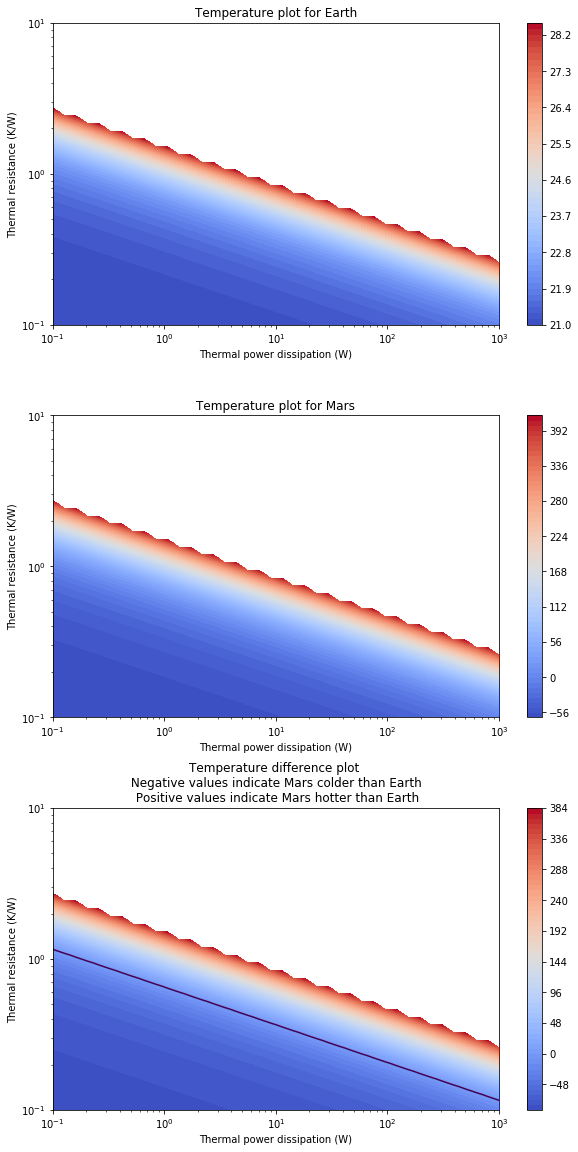

In [92]:
fig, axs = plt.subplots(3, figsize=(10,20))
plt.subplots_adjust(hspace=0.3)


cs0 = axs[0].contourf(powers, resistances, earth_temps, cmap="coolwarm", levels=64)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Thermal power dissipation (W)")
axs[0].set_ylabel("Thermal resistance (K/W)")
axs[0].set_title("Temperature plot for Earth")
fig.colorbar(cs0, ax=axs[0])

cs1 = axs[1].contourf(powers, resistances, mars_temps, cmap="coolwarm", levels=64)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Thermal power dissipation (W)")
axs[1].set_ylabel("Thermal resistance (K/W)")
axs[1].set_title("Temperature plot for Mars")

fig.colorbar(cs1, ax=axs[1])

cs2 = axs[2].contourf(powers, resistances, delta_temps, cmap="coolwarm", levels=64)
cs3 = axs[2].contour(powers, resistances, delta_temps, levels=[0])
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("Thermal power dissipation (W)")
axs[2].set_ylabel("Thermal resistance (K/W)")
axs[2].set_title("Temperature difference plot \n Negative values indicate Mars colder than Earth \n Positive values indicate Mars hotter than Earth")

fig.colorbar(cs2, ax=axs[2])

plt.show()

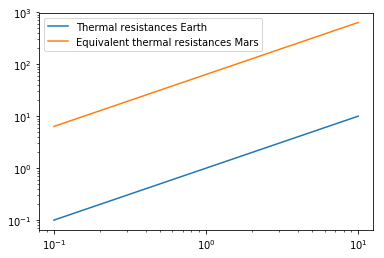

In [83]:
plt.plot(resistances, resistances, label="Thermal resistances Earth")
plt.plot(resistances, mars_resistances, label="Equivalent thermal resistances Mars")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()